In [19]:
#Importing the required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
# Loading the dataset
df = pd.read_csv(r"C:\Users\sabha\Downloads\Fraud.csv")

In [21]:
# 1.Cleaning the Dataset:

# Checking for missing values
print(df.isnull().sum())

# Imputing the missing values for `oldbalanceDest` and `newbalanceDest`
df['oldbalanceDest'].fillna(0, inplace=True)
df['newbalanceDest'].fillna(0, inplace=True)

# Handling outliers in 'amount', 'oldbalanceOrg', and 'newbalanceOrig'
from scipy import stats

# Using z-score and Removing rows where z-score > 3:
z_scores = np.abs(stats.zscore(df[['amount', 'oldbalanceOrg', 'newbalanceOrig']]))
df = df[(z_scores < 3).all(axis=1)]

# Feature Engineering: Differences between balances
df['balanceOrigDiff'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balanceDestDiff'] = df['oldbalanceDest'] - df['newbalanceDest']

# Droping unnecessary columns
df_cleaned = df.drop(['nameOrig', 'nameDest'], axis=1)

# Using One-Hot Encoding for the 'type' column (categorical)
df_cleaned = pd.get_dummies(df_cleaned, columns=['type'], drop_first=True)

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [22]:
# 2. Splitting the Dataset
X = df_cleaned.drop(['isFraud'], axis=1)
y = df_cleaned['isFraud']

# Spliting the data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [23]:
# 3. Data Standardization
scaler = StandardScaler()

# Standardizing the training set and test set
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
# 4. Applying PCA(Principal Component Analysis) for Dimensionality Reduction
# Retaining 95% of the variance
pca = PCA(n_components=0.95)  
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [25]:
# 5. Hyperparameter Tuning with RandomizedSearchCV for XGBoost
# Defining a smaller hyperparameter space for XGBoost
param_dist = {'n_estimators': [50, 100],'max_depth': [3, 5],'learning_rate': [0.05, 0.1],'subsample': [0.8, 1.0],
              'colsample_bytree': [0.8, 1.0],}

In [26]:
# 6. Initializing XGBoost model
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)

# Setting up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=10, scoring='roc_auc', 
                                   cv=2, random_state=42, n_jobs=-1)

# Training the XGBoost model with RandomizedSearchCV
random_search.fit(X_train_pca, y_train)

RandomizedSearchCV(cv=2,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'learning_rate': [0.05, 0.1],
                                        'max_depth': [3, 5],
                                        'n_estimators': [50, 100],
                                        'subsample': [0.8, 1.0]},
                   random_state=42, scoring='roc_auc')

In [27]:
# Model performance
print("Best Parameters from RandomizedSearchCV:\n", random_search.best_params_)
print("Best ROC AUC Score during CV:", random_search.best_score_)

Best Parameters from RandomizedSearchCV:
 {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Best ROC AUC Score during CV: 0.9961301786375607


In [28]:
# 7. Model Evaluation on the Test Set
y_pred_xgb_tuned = random_search.best_estimator_.predict(X_test_pca)

# Classification report
print("Tuned XGBoost Model - Classification Report:\n", classification_report(y_test, y_pred_xgb_tuned))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb_tuned))

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_xgb_tuned)
print("ROC AUC Score on Test Set:", roc_auc)

Tuned XGBoost Model - Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1846299
           1       0.29      0.63      0.40      1958

    accuracy                           1.00   1848257
   macro avg       0.64      0.81      0.70   1848257
weighted avg       1.00      1.00      1.00   1848257

Confusion Matrix:
 [[1843258    3041]
 [    725    1233]]
ROC AUC Score on Test Set: 0.8140385647720668


Feature importances: [0.06492452 0.26168275 0.03770053 0.03494101 0.03774565 0.05400763
 0.1320464  0.09046102 0.15732607 0.04100287 0.08816157]


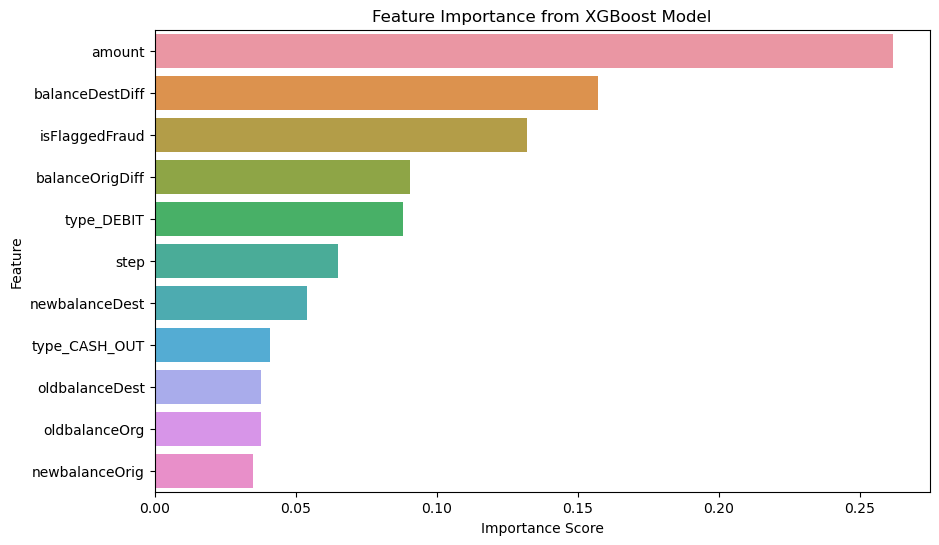

In [29]:
# 8. Feature importance analysis
importance = random_search.best_estimator_.feature_importances_
print("Feature importances:", importance)

features = X.columns
feature_importance = pd.DataFrame({'Feature': features[:len(importance)], 'Importance': importance})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title("Feature Importance from XGBoost Model")
plt.xlabel("Importance Score")
plt.show()

In [30]:
'''
1. Data Cleaning Including Missing Values, Outliers, and Multi-Collinearity.
Ans:
Missing Values: Missing values in the oldbalanceDest and newbalanceDest columns are handled by imputing them with zero.
Outliers: Outliers are detected and removed using the Z-score method for the amount, oldbalanceOrg, and newbalanceOrig columns. 
Rows with Z-scores greater than 3 are removed.
Feature Engineering: New features, balanceOrigDiff and balanceDestDiff, are created to capture differences between original and new balances.
Multi-Collinearity: PCA is used to handle multi-collinearity by transforming the features into orthogonal components, retaining 95% of the variance.

2. Describe Your Fraud Detection Model in Elaboration.
Ans:
Data Preparation: The dataset is cleaned and preprocessed, including handling missing values, outliers, and encoding categorical variables.
Feature Engineering: New features are engineered to potentially enhance the model’s performance.
Dimensionality Reduction: PCA (Principal Component Analysis) is applied to reduce the number of features while retaining most of the variance.
Model Selection: XGBoost is used for its efficiency and effectiveness in handling large datasets and binary classification tasks.
Hyperparameter Tuning: RandomizedSearchCV is used to find the optimal hyperparameters for XGBoost, improving model performance.

3. How Did You Select Variables to Be Included in the Model?
Ans:
Dropped Columns: Unnecessary columns (nameOrig and nameDest) are removed as they do not contribute to the predictive power of the model.
Feature Engineering: Additional features are created to capture important differences in balances.
One-Hot Encoding: The categorical feature 'type' is one-hot encoded to make it suitable for the model.
PCA: Dimensionality reduction through PCA helps in retaining relevant features while reducing multicollinearity and computational complexity.

4.Demonstrate the Performance of the Model by Using the Best Set of Tools.
Ans:
Classification Report: Provides detailed metrics including precision, recall, F1-score, and support for each class.
Confusion Matrix: Shows the count of true positives, true negatives, false positives, and false negatives.
ROC AUC Score: Measures the model’s ability to distinguish between classes.

5. What Are the Key Factors That Predict Fraudulent Customers?
Ans:
Feature Importance Scores: Obtained from the trained XGBoost model, these scores indicate which features are most influential in predicting fraud.
Visualization: A bar plot of feature importance helps in understanding the relative significance of each feature.

6. Do These Factors Make Sense? If Yes, How? If Not, How Not?
Ans:
Relevance: Features with high importance scores is examined for their relevance to fraud detection. 
For example, features capturing large discrepancies in balances might be indicative of fraudulent behavior.
Validation: The relevance of features is aligning with domain knowledge and known patterns of fraud. 
If some features seem counterintuitive, further investigation and domain expertise might be required.

7. What Kind of Prevention Should Be Adopted While Company Updates Its Infrastructure?
Ans:
Fraud Detection Systems: Implement real-time fraud detection systems using models like XGBoost to monitor transactions continuously.
Data Security: Strengthen data security measures to prevent unauthorized access and tampering.
Model Updates: Regularly update the fraud detection model with new data to keep it relevant to emerging fraud patterns.

8. Assuming These Actions Have Been Implemented, How Would You Determine if They Work?
Ans:
Monitoring: Track the performance of the fraud detection system using metrics such as detection rates, false positives, and false negatives.
A/B Testing: Compare the performance of the new system with previous systems using A/B testing to assess improvements.
Feedback Loop: Continuously gather feedback and refine the system based on real-world performance and emerging fraud trends.

'''

"\n1. Data Cleaning Including Missing Values, Outliers, and Multi-Collinearity.\nAns:\nMissing Values: Missing values in the oldbalanceDest and newbalanceDest columns are handled by imputing them with zero.\nOutliers: Outliers are detected and removed using the Z-score method for the amount, oldbalanceOrg, and newbalanceOrig columns. \nRows with Z-scores greater than 3 are removed.\nFeature Engineering: New features, balanceOrigDiff and balanceDestDiff, are created to capture differences between original and new balances.\nMulti-Collinearity: PCA is used to handle multi-collinearity by transforming the features into orthogonal components, retaining 95% of the variance.\n\n2. Describe Your Fraud Detection Model in Elaboration.\nAns:\nData Preparation: The dataset is cleaned and preprocessed, including handling missing values, outliers, and encoding categorical variables.\nFeature Engineering: New features are engineered to potentially enhance the model’s performance.\nDimensionality Red